In [6]:
#import geopandas as gpd
import numpy as np
import folium
import glob
import json
import os
#import rasterio as rio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from folium.plugins import HeatMap
from PIL import Image
#from rasterio import features
#from rasterio.warp import calculate_default_transform
#from rasterio.transform import from_bounds

In [4]:
'''
Hardcoding the single image tile used in phase one to get a working POC. 
These should be changed, accessed programmatically
PATH directory should be updated to conform to the standards set out in the instructions
PATH should be updated to use os.join.path
''' 

API_KEY = 'pk.eyJ1Ijoia25lZGxpa3kiLCJhIjoiY2t0NzN4OXg4MG9ueDJvcndoM3R3bjFvayJ9.y06YZbRFunBbKyD8HuKTlw'
PATH = ('./data')
X = 7680
Y = 10240
TCI = 'TCI'
BLUE = 'B02'
GREEN = 'B03'
RED = 'B04'
NIR = 'B08'
DATE = '2019-08-09'

TILE_WIDTH_PX = 512
TILE_HEIGHT_PX = 512
IS_IN_MASK_PIXEL_VALUE = (0, 0, 0, 255)

In [2]:
# get tile path
def get_tile_path(lat, lon, band, date):
    path = f'{PATH}/timeseries/{lat}-{lon}-{band}-{date}.png'
    return path


# get png mask path
def get_mask_path(lat, lon):
    path = f'{PATH}/masks/mask-x{lat}-y{lon}.png'
    return path


# get image as a PNG image file
def get_tile(tile_path):
    image = Image.open(tile_path)
    return image


# get mask as a PNG image file
def get_mask(mask_path):
    image = Image.open(mask_path)
    return image


# open image file and returns pixel object
def get_pixels(tile_path):
    image = Image.open(tile_path)
    pixels = image.load()
    return pixels


# returns an image as a numpy array
def get_pixels_array(tile_path):
    image = Image.open(tile_path)
    return np.array(image)


# creates an image from a numpy array
def create_image(np_array):
    return Image.fromarray(np_array)


# returns the south-east and north west corner of a tile
def get_bounds(lat, lon):
    with open(f'{PATH}/geometries/geo-x{lat}-y{lon}.geojson') as f:
        coordinates = json.load(f)['features'][0]['geometry']['coordinates']
        lon_min = coordinates[0][1][0]
        lat_min = coordinates[0][1][1]
        lon_max = coordinates[0][3][0]
        lat_max = coordinates[0][3][1]
        return [[lat_min, lon_min], [lat_max, lon_max]]


# returns an area of interest as a GeoPandas object
def get_aoi(lat, lon):
    return gpd.read_file(f'{PATH}/geometries/geo-x{lat}-y{lon}.geojson')
    
    
# returns the centroid of an area, in the form (lon, lat)
def get_centroid(lat, lon):
    [[x1, y1], [x2, y2]] = get_bounds(lat, lon)
    return [(x1 + x2)/ 2, (y1 + y2) / 2]


# returns a mask
def is_in_mask(mask_pixels, pixel_x, pixel_y):
    if mask_pixels[pixel_y, pixel_x] == IS_IN_MASK_PIXEL_VALUE:
        return True
    else:
        return False
    
    
# creates a mask to create a transparent layer for the VIs on each tile
def generate_mask(lat,lon):
    mask = get_pixels_array(get_mask_path(lat,lon))
    return np.all(mask == IS_IN_MASK_PIXEL_VALUE, axis = -1)


# returns a masked array    
def create_masked_raster(array, mask):
    return np.ma.MaskedArray(array, mask)

In [10]:
# vegetation index calculations
def calculate_ndvi(NIR, RED):
    return (NIR - RED) / (NIR + RED)


def calculate_gndvi(NIR, GREEN):
    return (NIR - GREEN) / (NIR + GREEN)


def calculate_endvi(NIR, GREEN, BLUE):
    return ((NIR + GREEN) - (2 * BLUE)) / ((NIR + GREEN) + (2 * BLUE)) 

In [8]:
# create a masked raster image based on a vegetation index
def create_vi_raster(mask, vi):
    minima = np.min(vi)
    maxima = np.max(vi)

    norm = Normalize(vmin = minima, vmax = maxima, clip = True)
    mapper = cm.ScalarMappable(norm = norm, cmap = cm.viridis)

    rgb = mapper.to_rgba(vi)
    rgb[~mask] = [0,0,0,0]

    return rgb

In [149]:
'''

left, bottom, right, top = bounds = features.bounds(get_aoi(X,Y))
source_transform = from_bounds(*bounds, TILE_WIDTH_PX, TILE_HEIGHT_PX)
dest_transform, dest_width, dest_height = calculate_default_transform({"init": "EPSG:4326"}, {"init": "EPSG:3857"}, 512, 512, left, bottom, right, top)

'''

'\n\nleft, bottom, right, top = bounds = features.bounds(get_aoi(X,Y))\nsource_transform = from_bounds(*bounds, TILE_WIDTH_PX, TILE_HEIGHT_PX)\ndest_transform, dest_width, dest_height = calculate_default_transform({"init": "EPSG:4326"}, {"init": "EPSG:3857"}, 512, 512, left, bottom, right, top)\n\n'

In [27]:
'''

import numpy as np
import rasterio
from rasterio import Affine as A
from rasterio.warp import reproject, Resampling

with rasterio.Env():

    # As source: a 512 x 512 raster centered on 0 degrees E and 0
    # degrees N, each pixel covering 15".
    rows, cols = src_shape = (TILE_WIDTH_PX, TILE_HEIGHT_PX)
    # d = 1.0/240 # decimal degrees per pixel
    # The following is equivalent to
    # A(d, 0, -cols*d/2, 0, -d, rows*d/2).
    src_transform = source_transform # A.translation(-cols*d/2, rows*d/2) * A.scale(d, -d)
    src_crs = {'init': 'EPSG:4326'}
    source = np.ones(src_shape, np.uint8)*255

    # Destination: a 1024 x 1024 dataset in Web Mercator (EPSG:3857)
    # with origin at 0.0, 0.0.
    dst_shape = (dest_width, dest_height)
    dst_transform = dest_transform #A.translation(-237481.5, 237536.4) * A.scale(425.0, -425.0)
    dst_crs = {'init': 'EPSG:3857'}
    destination = np.zeros(dst_shape, np.uint8)

    reproject(
            ndvi,
            destination,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)
        
    # Assert that the destination is only partly filled.
    assert destination.any()
    assert not destination.all()
    
'''

In [10]:
# method for generating map, and each layer.
# this can be broken up to generate, show layers for each NDVI and ...
# in the future, different satellite tiles
def create_map(lat, lon, date):
    m = folium.Map(
    location = get_centroid(lat,lon),
    tiles = None,
    zoom_start = 14
    )
    
    
    folium.TileLayer(
    name = 'Basemap',
    tiles = 'https://api.tiles.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}.png?access_token=' + API_KEY,
    attr = 'MapBox',
    overlay = False
    ).add_to(m)

    
    folium.GeoJson(
    data = get_aoi(lat,lon),
    name = 'Area of Interest'
    ).add_to(m)
    
    
    # TODO
    # Tile and mask need to be reprojected so that they align with map
    # https://rasterio.readthedocs.io/en/latest/topics/reproject.html?highlight=warp
    # This is complicated

    
    folium.raster_layers.ImageOverlay(
    name = 'Satellite Image',
    image = get_tile_path(lat, lon, TCI, date),
    bounds = get_bounds(lat,lon),
    show = False
    ).add_to(m)
    
    folium.raster_layers.ImageOverlay(
    name = 'Mask',
    image = mask,
    bounds = get_bounds(lat,lon),
    show = False
    ).add_to(m)


    folium.raster_layers.ImageOverlay(
    name ='NDVI',
    image = create_vi_raster(mask, ndvi),
    bounds = get_bounds(lat,lon),
    show = False
    ).add_to(m)


    folium.raster_layers.ImageOverlay(
    name ='GNDVI',
    image = create_vi_raster(mask, gndvi),
    bounds = get_bounds(lat,lon),
    show = False
    ).add_to(m)


    folium.raster_layers.ImageOverlay(
    name ='ENDVI',
    image = create_vi_raster(mask, endvi),
    bounds = get_bounds(lat,lon),
    show = False
    ).add_to(m)

    
    '''
    HeatMap(
        gndvi,
        name = 'Heat'
    ).add_to(m)
    '''
    
    
    folium.LayerControl().add_to(m)
    return m

In [11]:
# main part of the application
nir = get_pixels_array(get_tile_path(X, Y, NIR, DATE))
red = get_pixels_array(get_tile_path(X, Y, RED, DATE))
green = get_pixels_array(get_tile_path(X, Y, GREEN, DATE))
blue = get_pixels_array(get_tile_path(X, Y, BLUE, DATE))

ndvi = calculate_ndvi(nir, red)
gndvi = calculate_gndvi(nir, green)
endvi = calculate_endvi(nir, green, blue)

mask = generate_mask(X,Y)

#m = create_map(X, Y, DATE)
#m

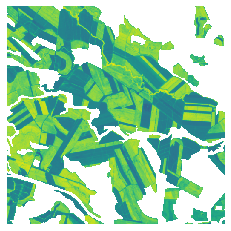

In [61]:
from PIL import Image
mask = generate_mask(X,Y)
raster = create_vi_raster(mask,ndvi)
image = plt.imshow(raster)
plt.axis('off')
#print(raster[0,0])
#img = Image.fromarray(raster, mode= 'RGBA')
#img.show()
#img.save('my.png')

plt.savefig('NDVI', transparent=True)
#plt.imsave('NDVI')


In [57]:
import plotly.express as px
mask = generate_mask(X,Y)
raster = create_vi_raster(mask,ndvi)
raster2 = (raster[:,:,:3] * 255).astype(int)
print(raster2.max())
print(raster2.min())


figure = px.imshow(raster2)
figure.show()

246
0


In [54]:
'''
TODO
Fix projection of numpy array into ImageOverlay object 
Alternatively, use HeatMap to display values as [lat,lon,value]
and/or HeatMapOverTime 
'''

'\nTODO\nFix projection of numpy array into ImageOverlay object \nAlternatively, use HeatMap to display values as [lat,lon,value]\nand/or HeatMapOverTime \n'

In [56]:
int_array = float_array.astype(int)
img_rgb = np.array([[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
                    [[0, 255, 0], [0, 0, 255], [255, 0, 0]]
                   ], dtype=np.uint8)
fig = px.imshow(img_rgb)
fig

In [58]:
img_rgb = np.array([[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
                    [[0, 255, 0], [0, 0, 255], [255, 0, 0]]
                   ], dtype=np.uint8)
fig = px.imshow(img_rgb)
fig.show()